# Section A: Convolutinal Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
Implement an image classifier using a deep learning network, to classify images into 11 classes of vegetables.<br/>
We will build two models for two different input sizes (23x23 and 101x101)<br/>
We want to compare the two classification models and their results

---

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import cv2
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
randomseed = 17

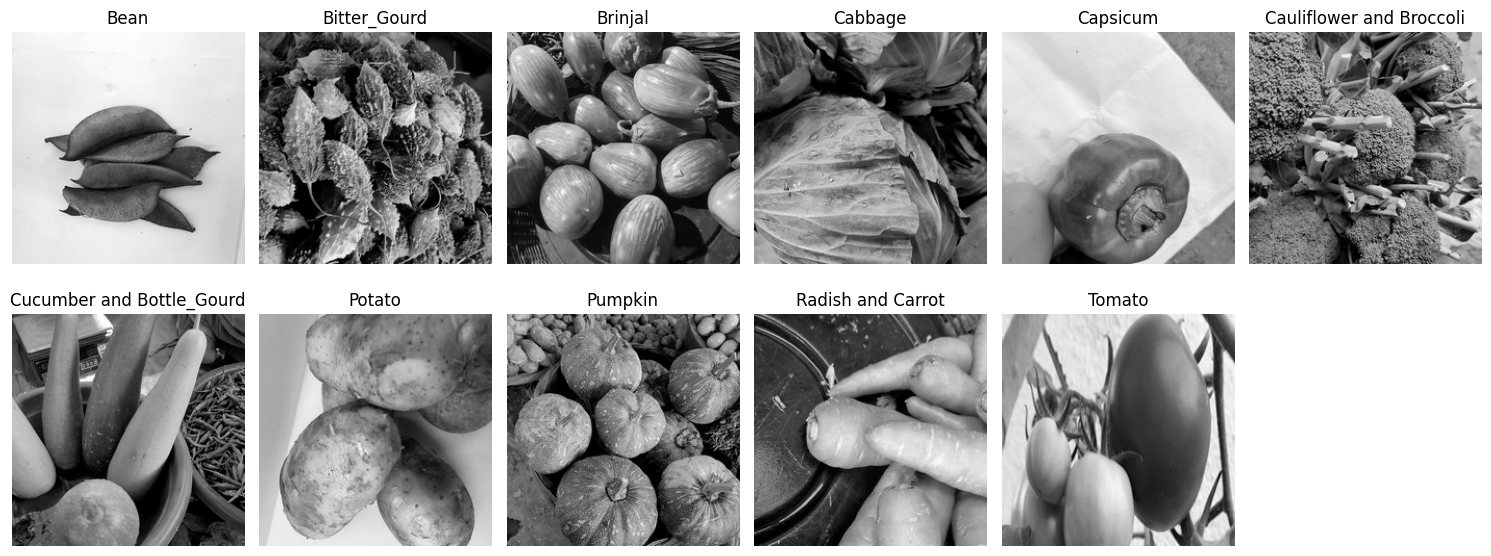

In [36]:
def show_images(folder_path):
    class_names = sorted(os.listdir(folder_path))
    plt.figure(figsize=(15, 6))
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(folder_path, cls)
        img_name = os.listdir(class_dir)[random.randint(0,9)]
        img = cv2.imread(os.path.join(class_dir, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images('Datasets/train')

# | Preprocess Data

From observation, there are many mistakes within the dataset (images in wrong class, incorrect class labels)
I had to remove images/rename file names.

In [37]:
import os

# Paths to dataset folders
base_path = 'Datasets'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

image_size_small = (23, 23)
image_size_large = (101, 101)

train_data_23 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
val_data_23 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
test_data_23 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')

train_data_101 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
val_data_101 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
test_data_101 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')

Found 7695 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7695 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [38]:
def seperate_dataset_object(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image)
        y.append(label)
    X = tf.concat(X, axis=0).numpy()
    y = tf.concat(y, axis=0).numpy()
    return X, y

X_train_23, y_train_23 = seperate_dataset_object(train_data_23)
X_val_23, y_val_23 = seperate_dataset_object(val_data_23)
X_test_23, y_test_23 = seperate_dataset_object(test_data_23)

X_train_101, y_train_101 = seperate_dataset_object(train_data_101)
X_val_101, y_val_101 = seperate_dataset_object(val_data_101)
X_test_101, y_test_101 = seperate_dataset_object(test_data_101)

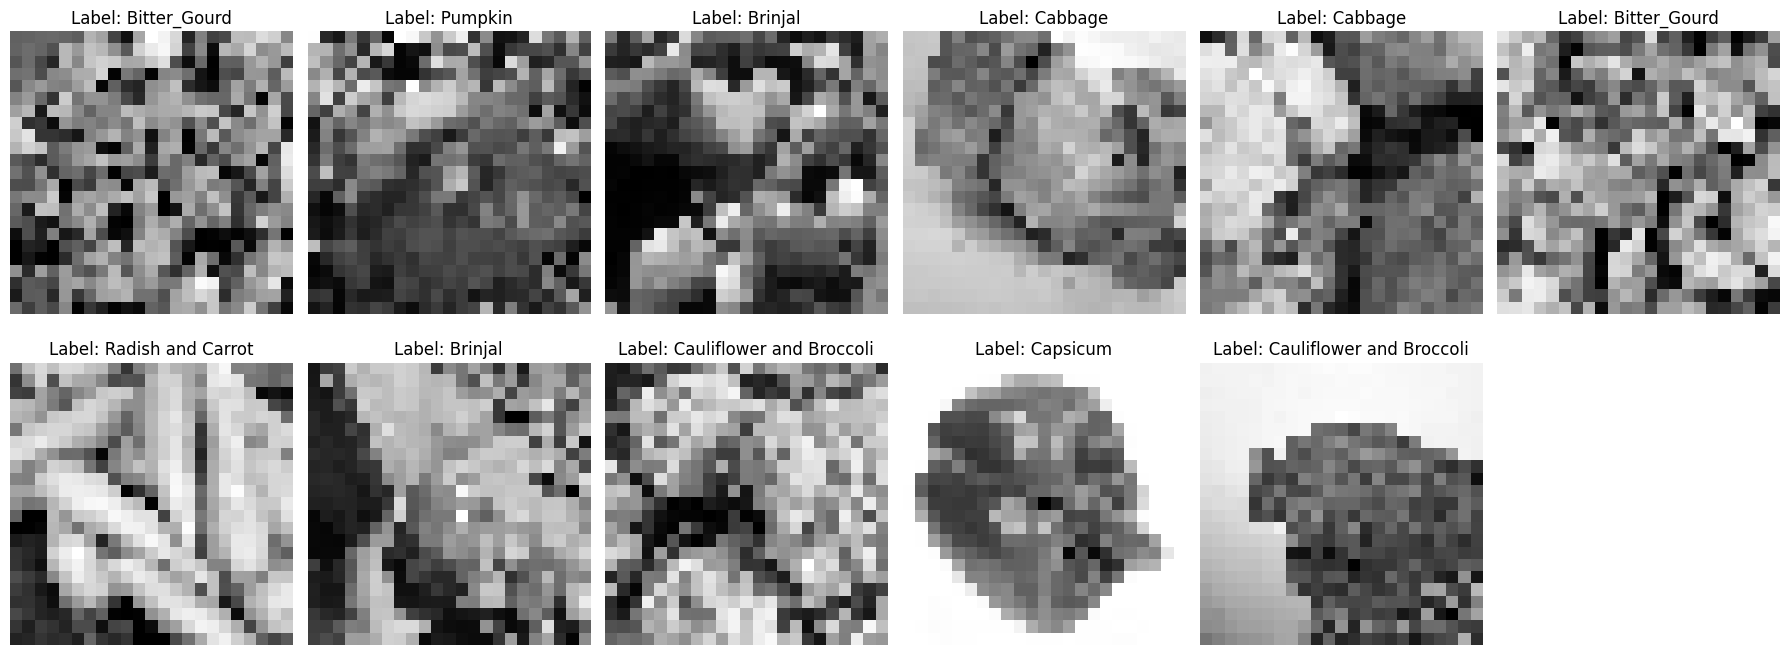

In [39]:
def show_sample_images(X, y, class_names):
    plt.figure(figsize=(18, 7))
    indices = random.sample(range(len(X)), len(class_names))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.title(f"Label: {class_names[y[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = sorted(os.listdir(train_path))
show_sample_images(X_train_23, y_train_23, class_names)

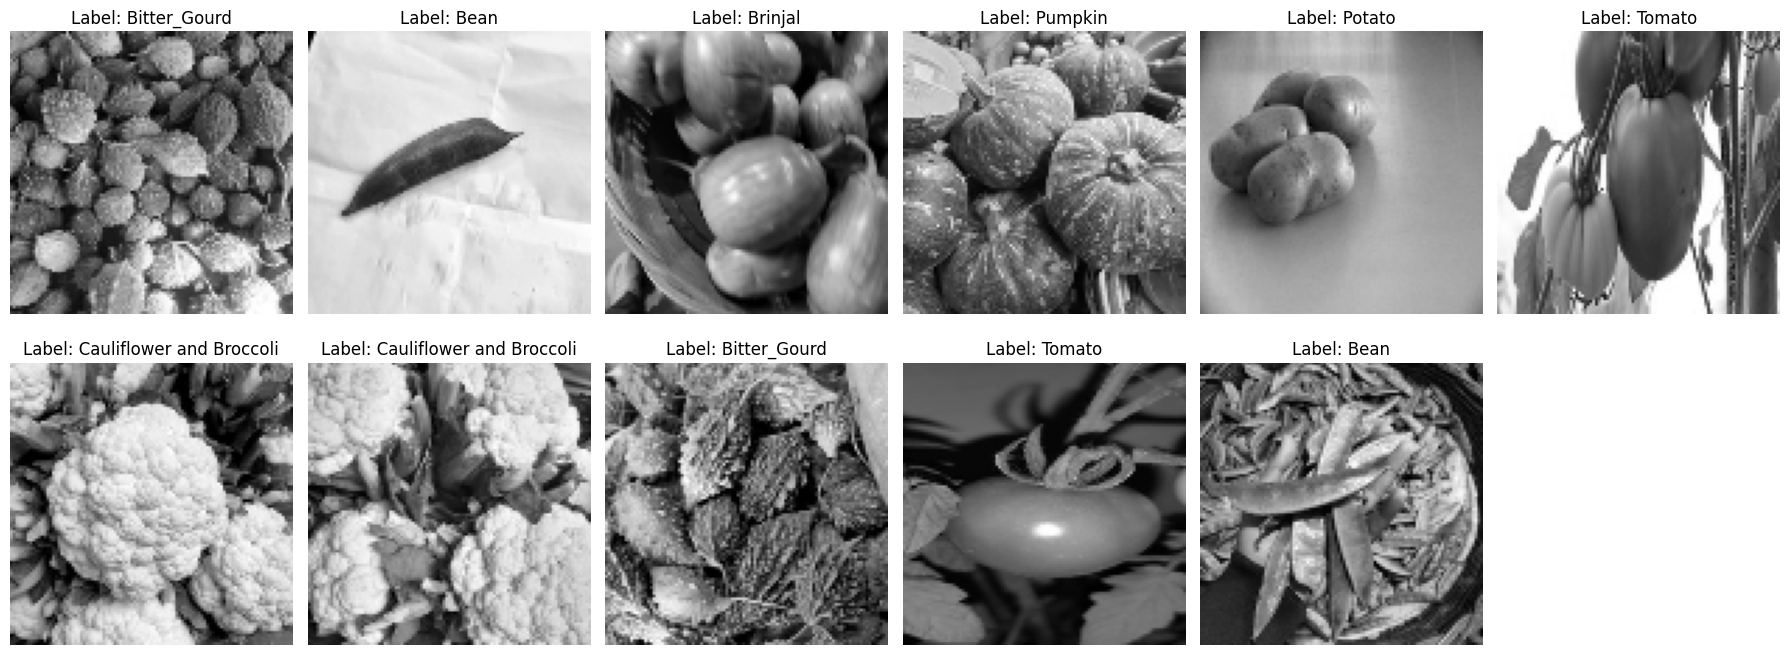

In [40]:
show_sample_images(X_train_101, y_train_101, class_names)

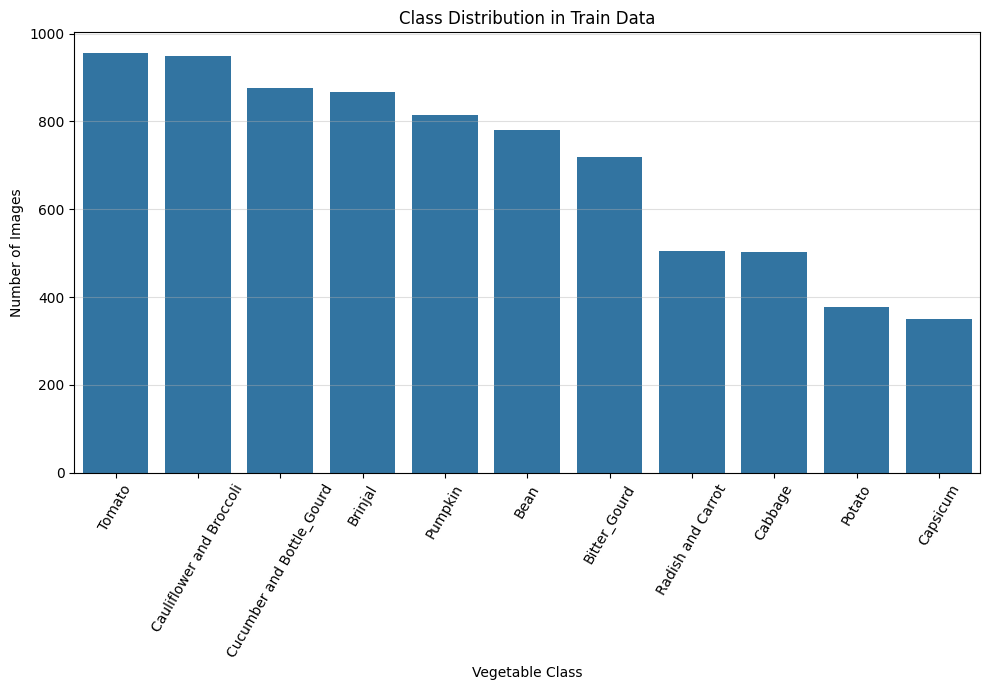

In [41]:
label_names = [class_names[idx] for idx in y_train_23]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Data")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

There is imbalance of data in the train dataset
- To solve this we will use class weights as an easy method to balance the data

In [42]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_23)),y=np.array(y_train_23))
# Convert to Series
class_weight_dict = pd.Series(class_weights, index=class_names)
print(f"Class weights: \n\n{class_weight_dict}")

Class weights: 

Bean                         0.896853
Bitter_Gourd                 0.971591
Brinjal                      0.805928
Cabbage                      1.390746
Capsicum                     1.993007
Cauliflower and Broccoli     0.737917
Cucumber and Bottle_Gourd    0.799481
Potato                       1.855558
Pumpkin                      0.859392
Radish and Carrot            1.387987
Tomato                       0.732508
dtype: float64


# | 23x23 Model

## Model training

In [43]:
from tensorflow.keras.utils import to_categorical

num_classes = len(class_names)
y_train_23_cat = to_categorical(y_train_23, num_classes)
y_val_23_cat = to_categorical(y_val_23, num_classes)
y_test_23_cat = to_categorical(y_test_23, num_classes)

In [108]:
def plot_learning_curve(history):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    # Training loss and validation loss
    ax1=ax[0]
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Number of Epochs")
    ax1.set_title("Training and Validation Loss")

    # Training accuracy and validation accuracy
    ax2=ax[1]
    ax2.plot(history.history["accuracy"], label="Training Accuracy")
    ax2.plot(history.history["val_accuracy"], label="Validation Accuracy")
    ax2.legend()
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Number of Epochs")
    ax2.set_title("Training and Validation Accuracy")
    plt.show()

In [91]:
baseline_37 = Sequential(name="baseline_37", layers = [
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 23, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

baseline_37.summary()

Model: "baseline_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 1, 1, 128)        

In [93]:
baseline_37.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [94]:
history = baseline_37.fit(
    X_train_23, y_train_23_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_23, y_val_23_cat),
)

Epoch 1/100
241/241 [==============================] - 2s 6ms/step - loss: 2.7387 - accuracy: 0.1229 - val_loss: 2.3665 - val_accuracy: 0.1327
Epoch 2/100
241/241 [==============================] - 1s 5ms/step - loss: 2.3269 - accuracy: 0.1388 - val_loss: 2.2924 - val_accuracy: 0.1777
Epoch 3/100
241/241 [==============================] - 1s 5ms/step - loss: 2.2469 - accuracy: 0.1801 - val_loss: 2.2292 - val_accuracy: 0.2277
Epoch 4/100
241/241 [==============================] - 1s 4ms/step - loss: 2.1742 - accuracy: 0.2149 - val_loss: 2.1605 - val_accuracy: 0.2318
Epoch 5/100
241/241 [==============================] - 1s 5ms/step - loss: 2.0830 - accuracy: 0.2621 - val_loss: 1.9899 - val_accuracy: 0.3205
Epoch 6/100
241/241 [==============================] - 1s 5ms/step - loss: 1.9775 - accuracy: 0.2993 - val_loss: 1.8599 - val_accuracy: 0.3764
Epoch 7/100
241/241 [==============================] - 1s 5ms/step - loss: 1.8532 - accuracy: 0.3567 - val_loss: 1.7509 - val_accuracy: 0.3941

In [ ]:
test_loss, test_acc = baseline_37.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 0s 4ms/step - loss: 2.4029 - accuracy: 0.7077
Test accuracy: 0.71


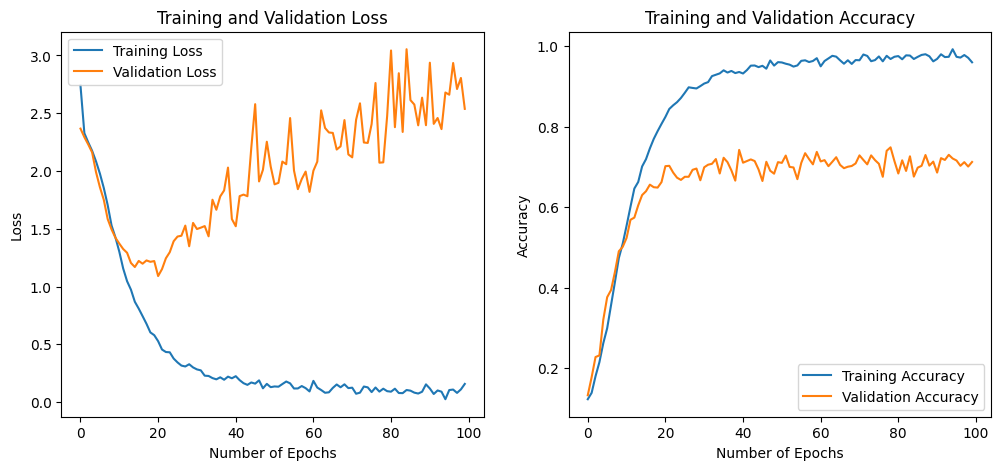

In [109]:
plot_learning_curve(history)

In [95]:
# callbacks = [
#     EarlyStopping(
#         monitor = "val_loss",
#         min_delta=1e-2,
#         patience=10,
#         verbose=1
#     )
# ]

I tried to implemet EarlyStopping, however the model would get stuck and not improve. Could be due to the way Early Stopping makes the model focus on one metric.

# 101x101 Model

## Model training

In [78]:
num_classes = len(class_names)
y_train_101_cat = to_categorical(y_train_101, num_classes)
y_val_101_cat = to_categorical(y_val_101, num_classes)
y_test_101_cat = to_categorical(y_test_101, num_classes)

In [79]:
baseline_101 = Sequential(name="baseline_101", layers = [
    Conv2D(64, (3, 3), activation='relu', input_shape=(101, 101, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(101, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

baseline_101.summary()

Model: "baseline_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 99, 99, 64)        640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 10, 256)     

In [80]:
baseline_101.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [81]:
history = baseline_101.fit(
    X_train_101, y_train_101_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_101, y_val_101_cat),
)

Epoch 1/100
241/241 [==============================] - 6s 23ms/step - loss: 3.3307 - accuracy: 0.1745 - val_loss: 2.2493 - val_accuracy: 0.2232
Epoch 2/100
241/241 [==============================] - 5s 22ms/step - loss: 2.1221 - accuracy: 0.2903 - val_loss: 1.9786 - val_accuracy: 0.3441
Epoch 3/100
241/241 [==============================] - 5s 22ms/step - loss: 1.8559 - accuracy: 0.3926 - val_loss: 1.7712 - val_accuracy: 0.4386
Epoch 4/100
241/241 [==============================] - 5s 22ms/step - loss: 1.6039 - accuracy: 0.4719 - val_loss: 1.5813 - val_accuracy: 0.5000
Epoch 5/100
241/241 [==============================] - 5s 22ms/step - loss: 1.3887 - accuracy: 0.5439 - val_loss: 1.4725 - val_accuracy: 0.5295
Epoch 6/100
241/241 [==============================] - 5s 22ms/step - loss: 1.2276 - accuracy: 0.5951 - val_loss: 1.3835 - val_accuracy: 0.5655
Epoch 7/100
241/241 [==============================] - 5s 22ms/step - loss: 1.1001 - accuracy: 0.6390 - val_loss: 1.3506 - val_accuracy:

In [83]:
test_loss, test_acc = baseline_101.evaluate(X_test_101, y_test_101_cat)
print(f"Test accuracy: {test_acc:.2f}")

69/69 [==============================] - 1s 8ms/step - loss: 3.0543 - accuracy: 0.7223
Test accuracy: 0.72


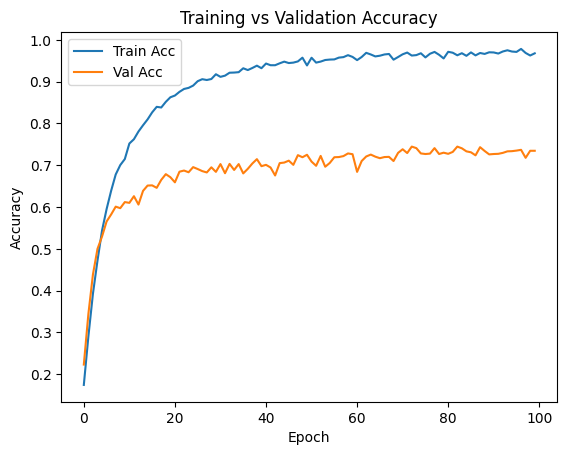

In [ ]:
plot_learning_curve(history)